In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
import pickle
import glob

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

# Scikit-learn for metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Set common plot size
plt.rcParams['figure.figsize'] = [10, 7]

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Global variables
IMAGE_SIZE = (320, 320)  # Standard input size for the model


In [11]:
# 1. Data Loading and Organization

def setup_paths(base_dir='D:/healthcare'):
    """
    Set up the paths for the dataset
    
    Args:
        base_dir: Base directory containing the dataset
        
    Returns:
        Dictionary with paths
    """
    paths = {
        'base_dir': base_dir,
        'csv_path': os.path.join(base_dir, 'Data_Entry_2017.csv'),
        'output_dir': os.path.join(base_dir, 'processed_data'),
        'model_dir': os.path.join(base_dir, 'models')
    }
    
    # Create output directories if they don't exist
    os.makedirs(paths['output_dir'], exist_ok=True)
    os.makedirs(paths['model_dir'], exist_ok=True)
    
    return paths

def find_all_images(base_dir):
    """
    Find all image files in the NIH dataset structure
    
    Args:
        base_dir: Base directory containing the dataset
        
    Returns:
        List of all image paths
    """
    # Pattern to match all images in all subdirectories
    image_pattern = os.path.join(base_dir, 'images_*/images/*.png')
    image_paths = glob.glob(image_pattern)
    
    # Create a mapping from image filename to full path for quick lookup
    image_map = {os.path.basename(path): path for path in image_paths}
    
    print(f"Found {len(image_paths)} images")
    return image_map

def prepare_data(paths, image_map):
    """
    Process the Data_Entry_2017.csv file and create train/valid/test splits
    
    Args:
        paths: Dictionary with paths
        image_map: Mapping from image filename to full path
        
    Returns:
        Processed dataframes for train, validation, and test sets
    """
    # Read the CSV file
    df = pd.read_csv(paths['csv_path'])
    
    # Extract pathology labels from the 'Finding Labels' column
    print("Processing CSV data...")
    
    # List of conditions we want to detect (matching the original notebook)
    conditions = [
        'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 
        'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 
        'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'
    ]
    
    # Initialize columns for each condition with zeros
    for condition in conditions:
        df[condition] = 0
    
    # Parse the 'Finding Labels' column to populate condition columns
    for index, row in df.iterrows():
        labels = row['Finding Labels'].split('|')
        for condition in conditions:
            if condition in labels:
                df.at[index, condition] = 1
    
    # Add path information
    df['path'] = df['Image Index'].apply(lambda x: image_map.get(x, ''))
    
    # Keep only rows where the image file was found
    df = df[df['path'] != '']
    
    # Create a new column 'Image' for compatibility with the original code
    df['Image'] = df['Image Index']
    
    # Split the data by patient to prevent data leakage
    # First split into train+valid and test
    patient_ids = df['Patient ID'].unique()
    train_valid_ids, test_ids = train_test_split(patient_ids, test_size=0.1, random_state=42)
    
    # Then split train+valid into train and valid
    train_ids, valid_ids = train_test_split(train_valid_ids, test_size=0.1, random_state=42)
    
    # Create dataframes for each split
    train_df = df[df['Patient ID'].isin(train_ids)].copy()
    valid_df = df[df['Patient ID'].isin(valid_ids)].copy()
    test_df = df[df['Patient ID'].isin(test_ids)].copy()
    
    print(f"Train set: {len(train_df)} images from {len(train_ids)} patients")
    print(f"Validation set: {len(valid_df)} images from {len(valid_ids)} patients")
    print(f"Test set: {len(test_df)} images from {len(test_ids)} patients")
    
    # Save processed dataframes
    train_df.to_csv(os.path.join(paths['output_dir'], 'train.csv'), index=False)
    valid_df.to_csv(os.path.join(paths['output_dir'], 'valid.csv'), index=False)
    test_df.to_csv(os.path.join(paths['output_dir'], 'test.csv'), index=False)
    
    return train_df, valid_df, test_df, conditions

def check_for_leakage(df1, df2, patient_col):
    """
    Check if there are any patients in both dataframes
    
    Args:
        df1: First dataframe
        df2: Second dataframe
        patient_col: Column name containing patient IDs
        
    Returns:
        Boolean indicating whether there is leakage
    """
    df1_patients = set(df1[patient_col].unique())
    df2_patients = set(df2[patient_col].unique())
    
    intersection = df1_patients.intersection(df2_patients)
    leakage = len(intersection) > 0
    
    if leakage:
        print(f"Warning: {len(intersection)} patients appear in both datasets!")
    
    return leakage

# 2. Data Visualization and Exploration

def explore_labels(train_df, conditions):
    """
    Explore and visualize the distribution of labels
    
    Args:
        train_df: Training dataframe
        conditions: List of conditions/diseases to analyze
    """
    # Count the occurrences of each condition
    condition_counts = train_df[conditions].sum().sort_values(ascending=False)
    
    # Calculate the prevalence
    prevalence = condition_counts / len(train_df)
    
    # Create a DataFrame for plotting
    prevalence_df = pd.DataFrame({
        'Condition': prevalence.index,
        'Prevalence': prevalence.values
    })
    
    # Plot the prevalence
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Prevalence', y='Condition', data=prevalence_df)
    plt.title('Prevalence of Each Condition in the Training Set')
    plt.xlabel('Prevalence')
    plt.ylabel('Condition')
    plt.tight_layout()
    plt.show()
    
    return prevalence

def visualize_sample_images(df, image_col='path', num_images=9):
    """
    Display a random sample of images from the dataframe
    
    Args:
        df: Dataframe containing image paths
        image_col: Column name for image paths
        num_images: Number of images to display
    """
    # Get random sample of images
    sample_indices = np.random.choice(len(df), size=num_images, replace=False)
    sample_images = df.iloc[sample_indices]
    
    # Create a figure
    plt.figure(figsize=(15, 15))
    
    # Display each image
    for i, (_, row) in enumerate(sample_images.iterrows()):
        plt.subplot(3, 3, i + 1)
        img = plt.imread(row[image_col])
        plt.imshow(img, cmap='gray')
        plt.title(f"Patient: {row['Patient ID']}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_image_properties(df, image_col='path'):
    """
    Analyze properties of images in the dataset
    
    Args:
        df: Dataframe containing image paths
        image_col: Column name for image paths
    """
    # Sample a few images
    sample_img_path = df[image_col].iloc[0]
    img = plt.imread(sample_img_path)
    
    # Display the sample image
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.title('Sample Chest X-Ray Image')
    plt.grid(False)
    plt.show()
    
    # Display histogram of pixel values
    plt.figure(figsize=(10, 6))
    plt.hist(img.ravel(), bins=50)
    plt.title('Distribution of Pixel Intensities')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()
    
    # Calculate and display statistics
    print(f"Image shape: {img.shape}")
    print(f"Pixel value range: {img.min()} to {img.max()}")
    print(f"Mean pixel value: {img.mean():.4f}")
    print(f"Pixel standard deviation: {img.std():.4f}")
    
    return img

# 3. Data Preprocessing and Generators

def compute_class_weights(labels):
    """
    Compute positive and negative weights for each class
    
    Args:
        labels: Binary labels array
        
    Returns:
        Positive and negative frequency arrays
    """
    # Get the number of samples
    N = labels.shape[0]
    
    # Compute positive and negative frequencies for each class
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = (N - np.sum(labels, axis=0)) / N
    
    return positive_frequencies, negative_frequencies

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Create a weighted loss function to address class imbalance
    
    Args:
        pos_weights: Array of positive weights for each class
        neg_weights: Array of negative weights for each class
        epsilon: Small constant to prevent log(0)
        
    Returns:
        Weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Calculate weighted binary cross-entropy loss
        
        Args:
            y_true: True labels
            y_pred: Predicted probabilities
            
        Returns:
            Weighted loss value
        """
        # Initialize loss
        loss = 0.0
        
        # Cast y_true to float32 to ensure type consistency
        y_true = tf.cast(y_true, tf.float32)
        
        # For each class, add weighted loss
        for i in range(len(pos_weights)):
            # For positive examples: -pos_weight * log(y_pred)
            # For negative examples: -neg_weight * log(1-y_pred)
            loss += -pos_weights[i] * K.mean(y_true[:, i] * K.log(y_pred[:, i] + epsilon)) \
                    -neg_weights[i] * K.mean((1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
        
        return loss
    
    return weighted_loss

def get_train_generator(df, image_col='path', label_cols=None, batch_size=32, target_size=IMAGE_SIZE):
    """
    Create an image generator for the training data with per-sample normalization
    
    Args:
        df: Training dataframe
        image_col: Column name for image paths
        label_cols: List of columns containing labels
        batch_size: Batch size for training
        target_size: Target image dimensions
        
    Returns:
        Training data generator
    """
    # Create an image data generator with per-sample normalization
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True,
        rotation_range=5,  # slight rotation for augmentation
        width_shift_range=0.05,  # slight horizontal shift for augmentation
        height_shift_range=0.05,  # slight vertical shift for augmentation
        zoom_range=0.05  # slight zoom for augmentation
    )
    
    # Create a generator for the training data
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=None,  # Images already have full paths
        x_col=image_col,
        y_col=label_cols,
        class_mode='raw',  # Return labels as raw values
        batch_size=batch_size,
        shuffle=True,
        target_size=target_size,
        validate_filenames=False  # Skip validation as we've already checked paths
    )
    
    return generator

def get_validation_test_generators(train_df, valid_df, test_df, image_col='path', label_cols=None, 
                                  batch_size=32, target_size=IMAGE_SIZE):
    """
    Create generators for validation and test data using normalization stats from training data
    
    Args:
        train_df: Training dataframe for normalization statistics
        valid_df: Validation dataframe
        test_df: Test dataframe
        image_col: Column name for image paths
        label_cols: List of columns containing labels
        batch_size: Batch size
        target_size: Target image dimensions
        
    Returns:
        Validation and test data generators
    """
    # Use a sample of training data to calculate normalization statistics
    sample_size = min(100, len(train_df))
    sample_indices = np.random.choice(len(train_df), size=sample_size, replace=False)
    sample_paths = train_df.iloc[sample_indices][image_col].values
    
    # Load sample images
    sample_images = []
    for path in sample_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        sample_images.append(img)
    
    # Stack images into a batch
    sample_batch = np.stack(sample_images)
    
    # Calculate mean and std for the sample
    mean = np.mean(sample_batch)
    std = np.std(sample_batch)
    
    # Create an image generator with featurewise normalization
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )
    
    # Set the normalization statistics
    image_generator.mean = mean
    image_generator.std = std
    
    # Create a generator for validation data
    valid_generator = image_generator.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col=image_col,
        y_col=label_cols,
        class_mode='raw',
        batch_size=batch_size,
        shuffle=False,
        target_size=target_size,
        validate_filenames=False
    )
    
    # Create a generator for test data
    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        directory=None,
        x_col=image_col,
        y_col=label_cols,
        class_mode='raw',
        batch_size=batch_size,
        shuffle=False,
        target_size=target_size,
        validate_filenames=False
    )
    
    return valid_generator, test_generator, (mean, std)

# 4. Model Building and Training

def build_model(num_classes, weights_path=None):
    """
    Build and compile the DenseNet121 model
    
    Args:
        num_classes: Number of output classes
        weights_path: Path to pre-trained weights (optional)
        
    Returns:
        Compiled model
    """
    # Load DenseNet121 with ImageNet weights
    base_model = DenseNet121(
        weights='imagenet', 
        include_top=False, 
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Load custom weights if provided
    if weights_path and os.path.exists(weights_path):
        print(f"Loading weights from {weights_path}")
        model.load_weights(weights_path)
    
    return model

def train_model(model, train_generator, valid_generator, pos_weights, neg_weights, 
                epochs=30, callbacks=None, model_dir=None):
    """
    Train the model with the provided generators
    
    Args:
        model: Model to train
        train_generator: Training data generator
        valid_generator: Validation data generator
        pos_weights: Positive class weights
        neg_weights: Negative class weights
        epochs: Number of epochs to train
        callbacks: List of Keras callbacks
        model_dir: Directory to save model weights
        
    Returns:
        Training history
    """
    # Compile the model with the weighted loss function
    model.compile(
        optimizer='adam',
        loss=get_weighted_loss(pos_weights, neg_weights)
    )
    
    # Create default callbacks if none provided
    if callbacks is None:
        callbacks = []
        
        # ModelCheckpoint to save the best model
        if model_dir:
            checkpoint_path = os.path.join(model_dir, 'best_model.h5')
            checkpoint = ModelCheckpoint(
                checkpoint_path,
                monitor='val_loss',
                save_best_only=True,
                mode='min',
                verbose=1
            )
            callbacks.append(checkpoint)
        
        # ReduceLROnPlateau to reduce learning rate when metrics plateau
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
        callbacks.append(reduce_lr)
        
        # EarlyStopping to prevent overfitting
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save the final model
    if model_dir:
        final_model_path = os.path.join(model_dir, 'final_model.h5')
        model.save_weights(final_model_path)
        print(f"Saved final model weights to {final_model_path}")
    
    return history

def evaluate_model(model, test_generator, conditions):
    """
    Evaluate the model on the test set and compute metrics
    
    Args:
        model: Trained model
        test_generator: Test data generator
        conditions: List of conditions being predicted
        
    Returns:
        Dictionary with evaluation results
    """
    # Make predictions on the test set
    print("Making predictions on the test set...")
    test_steps = len(test_generator)
    predictions = model.predict(test_generator, steps=test_steps)
    
    # Get the true labels
    true_labels = test_generator.labels
    
    # Compute ROC AUC for each condition
    print("Computing ROC AUC scores...")
    auc_scores = {}
    
    plt.figure(figsize=(12, 12))
    plt.plot([0, 1], [0, 1], 'k--')
    
    for i, condition in enumerate(conditions):
        try:
            # Get true labels and predictions for this condition
            y_true = true_labels[:, i]
            y_pred = predictions[:, i]
            
            # Compute ROC AUC
            auc = roc_auc_score(y_true, y_pred)
            auc_scores[condition] = auc
            
            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            
            # Plot ROC curve
            plt.plot(fpr, tpr, label=f'{condition} (AUC = {auc:.3f})')
            
        except Exception as e:
            print(f"Error computing ROC AUC for {condition}: {e}")
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='best')
    plt.show()
    
    # Compute average AUC
    avg_auc = np.mean(list(auc_scores.values()))
    print(f"Average AUC: {avg_auc:.3f}")
    
    # Sort conditions by AUC
    sorted_auc = {k: v for k, v in sorted(auc_scores.items(), key=lambda item: item[1], reverse=True)}
    
    # Print AUC scores
    for condition, auc in sorted_auc.items():
        print(f"{condition}: AUC = {auc:.3f}")
    
    return {
        'predictions': predictions,
        'true_labels': true_labels,
        'auc_scores': auc_scores,
        'avg_auc': avg_auc
    }

# 5. Model Interpretation with GradCAM

def grad_cam(model, img, category_index, layer_name):
    """
    Generate GradCAM heatmap for a given image and class
    
    Args:
        model: Trained model
        img: Input image (preprocessed and expanded to batch dimension)
        category_index: Index of the category to visualize
        layer_name: Name of the convolutional layer to use for GradCAM
        
    Returns:
        GradCAM heatmap
    """
    # Get the model's output for the specified category
    output = model.output[:, category_index]
    
    # Get the specified layer
    last_conv_layer = model.get_layer(layer_name)
    
    # Compute gradients of the output with respect to the layer
    grads = K.gradients(output, last_conv_layer.output)[0]
    
    # Pool the gradients over all spatial dimensions
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # Create a function to get the output of the layer and the pooled gradients
    iterate = K.function([model.input], [last_conv_layer.output, pooled_grads])
    
    # Get the output and pooled gradients for the input image
    conv_output, pooled_grads_value = iterate([img])
    conv_output_value = conv_output[0]
    
    # Multiply each channel in the feature map by its importance
    for i in range(pooled_grads_value.shape[0]):
        conv_output_value[:, :, i] *= pooled_grads_value[i]
    
    # Create the heatmap
    heatmap = np.mean(conv_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU operation
    
    # Normalize the heatmap
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    
    # Resize heatmap to match input image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[2]))
    
    return heatmap

def preprocess_image_for_gradcam(image_path, mean, std, target_size=IMAGE_SIZE):
    """
    Preprocess an image for GradCAM visualization
    
    Args:
        image_path: Path to the image file
        mean: Mean value for normalization
        std: Standard deviation for normalization
        target_size: Target size for the image
        
    Returns:
        Preprocessed image with batch dimension
    """
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    
    # Convert to float and normalize
    img = img.astype(np.float32) / 255.0
    img = (img - mean) / std
    
    # Add channel dimension for grayscale
    img = np.expand_dims(img, axis=-1)
    
    # Repeat the single channel to make it 3-channel (for DenseNet input)
    img = np.repeat(img, 3, axis=-1)
    
    # Add batch dimension
    img = np.expand_dims(img, axis=0)
    
    return img

def load_raw_image(image_path, target_size=IMAGE_SIZE):
    """
    Load an image without preprocessing for display
    
    Args:
        image_path: Path to the image file
        target_size: Target size for the image
        
    Returns:
        Raw image
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    return img

def visualize_gradcam(model, image_path, conditions, df, mean, std, selected_conditions=None, 
                     layer_name='conv5_block16_concat'):
    """
    Generate and visualize GradCAM for selected conditions
    
    Args:
        model: Trained model
        image_path: Path to the image file
        conditions: List of all conditions
        df: Dataframe with ground truth labels
        mean: Mean value for normalization
        std: Standard deviation for normalization
        selected_conditions: List of conditions to visualize (or None for top predictions)
        layer_name: Name of the layer to use for GradCAM
    """
    # Get the image filename
    image_filename = os.path.basename(image_path)
    
    # Preprocess the image for the model
    processed_img = preprocess_image_for_gradcam(image_path, mean, std)
    
    # Get model predictions
    predictions = model.predict(processed_img)[0]
    
    # Get ground truth if available
    ground_truth = []
    if image_filename in df['Image Index'].values:
        row = df[df['Image Index'] == image_filename].iloc[0]
        ground_truth = [conditions[i] for i in range(len(conditions)) if row[conditions[i]] == 1]
        
    print(f"Ground Truth: {', '.join(ground_truth) if ground_truth else 'Unknown'}")
    
    # If no conditions are specified, use the top 3 predicted conditions
    if selected_conditions is None:
        top_indices = np.argsort(predictions)[::-1][:3]
        selected_conditions = [conditions[i] for i in top_indices]
    
    # Load the raw image for display
    raw_img = load_raw_image(image_path)
    
    # Set up the figure
    num_plots = 1 + len(selected_conditions)
    fig, axs = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
    
    # Show the original image
    if num_plots == 1:
        axs = [axs]  # Make axs a list if there's only one subplot
    
    axs[0].imshow(raw_img, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')
    
    # Generate and show GradCAM for each selected condition
    for i, condition in enumerate(selected_conditions):
        condition_idx = conditions.index(condition)
        prediction = predictions[condition_idx]
        
        # Generate GradCAM
        heatmap = grad_cam(model, processed_img, condition_idx, layer_name)
        
        # Display the heatmap overlaid on the original image
        axs[i + 1].imshow(raw_img, cmap='gray')
        axs[i + 1].imshow(heatmap, cmap='jet', alpha=min(0.5, prediction + 0.2))
        axs[i + 1].set_title(f"{condition}: {prediction:.3f}")
        axs[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# 6. Main Execution Pipeline

def main():
    """
    Main execution pipeline
    """
    # Setup paths
    paths = setup_paths()
    
    # Find all images
    image_map = find_all_images(paths['base_dir'])
    
    # Prepare data
    train_df, valid_df, test_df, conditions = prepare_data(paths, image_map)
    
    # Check for data leakage
    print("\nChecking for data leakage...")
    check_for_leakage(train_df, valid_df, 'Patient ID')
    check_for_leakage(train_df, test_df, 'Patient ID')
    check_for_leakage(valid_df, test_df, 'Patient ID')
    
    # Explore data
    print("\nExploring data distribution...")
    prevalence = explore_labels(train_df, conditions)
    
    # Visualize sample images
    print("\nVisualizing sample images...")
    visualize_sample_images(train_df)
    
    # Analyze image properties
    print("\nAnalyzing image properties...")
    sample_img = analyze_image_properties(train_df)
    
    # Create data generators
    print("\nCreating data generators...")
    
    # Calculate class weights to handle imbalance
    pos_weights, neg_weights = compute_class_weights(train_df[conditions].values)
    
    # Create training generator with augmentation
    train_generator = get_train_generator(
        train_df, 
        image_col='path', 
        label_cols=conditions, 
        batch_size=32
    )
    
    # Create validation and test generators
    valid_generator, test_generator, norm_stats = get_validation_test_generators(
        train_df, valid_df, test_df, 
        image_col='path', 
        label_cols=conditions, 
        batch_size=32
    )
    
    # Build the model
    print("\nBuilding and compiling model...")
    model = build_model(num_classes=len(conditions))
    
    # Train the model
    print("\nTraining model...")
    history = train_model(
        model,
        train_generator,
        valid_generator,
        pos_weights,
        neg_weights,
        epochs=30,
        model_dir=paths['model_dir']
    )
    
    # Visualize training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Evaluate the model on the test set
    print("\nEvaluating model on test set...")
    evaluation = evaluate_model(model, test_generator, conditions)
    
    # Save evaluation results
    evaluation_path = os.path.join(paths['output_dir'], 'evaluation_results.pkl')
    with open(evaluation_path, 'wb') as f:
        pickle.dump(evaluation, f)
    print(f"Saved evaluation results to {evaluation_path}")
    
    # Visualize model predictions on a few test samples with GradCAM
    print("\nVisualizing model predictions with GradCAM...")
    
    # Select a few random test samples for visualization
    sample_size = min(5, len(test_df))
    sample_indices = np.random.choice(len(test_df), size=sample_size, replace=False)
    sample_images = test_df.iloc[sample_indices]
    
    # For each sample, generate GradCAM visualizations
    for _, row in sample_images.iterrows():
        image_path = row['path']
        visualize_gradcam(
            model, 
            image_path, 
            conditions, 
            test_df, 
            norm_stats[0], 
            norm_stats[1]
        )

# 7. Advanced Model Analysis and Deployment

def visualize_attention_map_on_dataset(model, df, conditions, mean, std, layer_name='conv5_block16_concat', 
                                      num_samples=10, threshold=0.5):
    """
    Visualize attention maps for samples with high confidence predictions
    
    Args:
        model: Trained model
        df: Dataframe containing samples to analyze
        conditions: List of conditions
        mean: Mean value for normalization
        std: Standard deviation for normalization
        layer_name: Name of the layer to use for attention map
        num_samples: Number of samples to visualize
        threshold: Confidence threshold for positive predictions
    """
    # Select conditions with highest prevalence
    top_conditions = sorted([(c, df[c].sum()) for c in conditions], key=lambda x: x[1], reverse=True)[:5]
    
    for condition_name, _ in top_conditions:
        condition_idx = conditions.index(condition_name)
        
        # Get positive samples for this condition
        positive_samples = df[df[condition_name] == 1]
        
        if len(positive_samples) == 0:
            print(f"No positive samples found for {condition_name}")
            continue
        
        # Select random samples
        if len(positive_samples) > num_samples:
            sample_indices = np.random.choice(len(positive_samples), size=num_samples, replace=False)
            samples = positive_samples.iloc[sample_indices]
        else:
            samples = positive_samples
        
        print(f"\nVisualizing attention maps for {condition_name} ({len(samples)} samples)")
        
        for _, row in samples.iterrows():
            image_path = row['path']
            
            # Preprocess the image
            processed_img = preprocess_image_for_gradcam(image_path, mean, std)
            
            # Get model prediction
            prediction = model.predict(processed_img)[0][condition_idx]
            
            # Skip if prediction confidence is below threshold
            if prediction < threshold:
                continue
            
            # Generate attention map
            heatmap = grad_cam(model, processed_img, condition_idx, layer_name)
            
            # Load raw image for display
            raw_img = load_raw_image(image_path)
            
            # Create visualization
            plt.figure(figsize=(15, 5))
            
            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(raw_img, cmap='gray')
            plt.title('Original')
            plt.axis('off')
            
            # Heatmap only
            plt.subplot(1, 3, 2)
            plt.imshow(heatmap, cmap='jet')
            plt.title('Attention Map')
            plt.axis('off')
            
            # Overlaid image
            plt.subplot(1, 3, 3)
            plt.imshow(raw_img, cmap='gray')
            plt.imshow(heatmap, cmap='jet', alpha=0.4)
            plt.title(f"{condition_name}: {prediction:.3f}")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

def analyze_classification_errors(model, test_generator, test_df, conditions, mean, std, 
                                 threshold=0.5, layer_name='conv5_block16_concat'):
    """
    Analyze classification errors on the test set
    
    Args:
        model: Trained model
        test_generator: Test data generator
        test_df: Test dataframe
        conditions: List of conditions
        mean: Mean value for normalization
        std: Standard deviation for normalization
        threshold: Classification threshold
        layer_name: Name of the layer to use for attention map
    """
    # Make predictions on the test set
    predictions = model.predict(test_generator, steps=len(test_generator))
    
    # Convert predictions to binary using threshold
    binary_preds = (predictions >= threshold).astype(int)
    
    # Get true labels
    true_labels = test_generator.labels
    
    # Calculate error metrics for each condition
    error_metrics = {}
    for i, condition in enumerate(conditions):
        # Get true and predicted labels for this condition
        y_true = true_labels[:, i]
        y_pred = binary_preds[:, i]
        y_score = predictions[:, i]
        
        # Calculate metrics
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        
        # Calculate precision, recall, and F1 score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Store metrics
        error_metrics[condition] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn
        }
        
        print(f"{condition}:")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1 Score: {f1:.3f}")
    
    # Find false positives and false negatives for visualization
    for i, condition in enumerate(conditions):
        print(f"\nAnalyzing errors for {condition}")
        
        # Get false positives
        fp_mask = (true_labels[:, i] == 0) & (binary_preds[:, i] == 1)
        fp_indices = np.where(fp_mask)[0]
        
        # Get false negatives
        fn_mask = (true_labels[:, i] == 1) & (binary_preds[:, i] == 0)
        fn_indices = np.where(fn_mask)[0]
        
        # Sample a few errors for analysis
        for error_type, indices in [('False Positive', fp_indices), ('False Negative', fn_indices)]:
            if len(indices) > 0:
                sample_size = min(3, len(indices))
                sample_indices = np.random.choice(indices, size=sample_size, replace=False)
                
                for idx in sample_indices:
                    # Get image path
                    if idx < len(test_df):
                        image_path = test_df.iloc[idx]['path']
                        
                        # Preprocess the image
                        processed_img = preprocess_image_for_gradcam(image_path, mean, std)
                        
                        # Generate attention map
                        heatmap = grad_cam(model, processed_img, i, layer_name)
                        
                        # Load raw image for display
                        raw_img = load_raw_image(image_path)
                        
                        # Create visualization
                        plt.figure(figsize=(10, 5))
                        
                        # Original image
                        plt.subplot(1, 2, 1)
                        plt.imshow(raw_img, cmap='gray')
                        plt.title('Original')
                        plt.axis('off')
                        
                        # Overlaid image
                        plt.subplot(1, 2, 2)
                        plt.imshow(raw_img, cmap='gray')
                        plt.imshow(heatmap, cmap='jet', alpha=0.4)
                        plt.title(f"{error_type} - Score: {predictions[idx, i]:.3f}")
                        plt.axis('off')
                        
                        plt.tight_layout()
                        plt.show()
                        
                        # Print patient information for context
                        patient_id = test_df.iloc[idx]['Patient ID']
                        patient_gender = test_df.iloc[idx]['Patient Gender']
                        patient_age = test_df.iloc[idx]['Patient Age']
                        
                        print(f"Patient ID: {patient_id}, Gender: {patient_gender}, Age: {patient_age}")
                        print(f"Prediction Score: {predictions[idx, i]:.3f}")
                        
                        # Print other conditions for this patient
                        other_conditions = [conditions[j] for j in range(len(conditions)) 
                                           if true_labels[idx, j] == 1 and j != i]
                        if other_conditions:
                            print(f"Other conditions: {', '.join(other_conditions)}")
                        print()

def create_deployment_pipeline(model, mean, std):
    """
    Create a deployment pipeline for inference
    
    Args:
        model: Trained model
        mean: Mean value for normalization
        std: Standard deviation for normalization
        
    Returns:
        Pipeline function for inference
    """
    def predict_single_image(image_path, conditions, threshold=0.5):
        """
        Predict conditions from a single chest X-ray image
        
        Args:
            image_path: Path to the image file
            conditions: List of conditions the model was trained on
            threshold: Classification threshold
            
        Returns:
            Dictionary with prediction results
        """
        # Preprocess the image
        processed_img = preprocess_image_for_gradcam(image_path, mean, std)
        
        # Get model predictions
        start_time = time.time()
        predictions = model.predict(processed_img)[0]
        inference_time = time.time() - start_time
        
        # Convert to dictionary of condition -> probability
        results = {
            conditions[i]: float(predictions[i]) 
            for i in range(len(conditions))
        }
        
        # Sort by probability (descending)
        sorted_results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}
        
        # Get binary predictions using threshold
        binary_predictions = [conditions[i] for i in range(len(conditions)) if predictions[i] >= threshold]
        
        return {
            'probabilities': sorted_results,
            'predictions': binary_predictions,
            'inference_time': inference_time
        }
    
    return predict_single_image

def save_deployment_artifacts(model, mean, std, conditions, output_dir):
    """
    Save deployment artifacts for future use
    
    Args:
        model: Trained model
        mean: Mean value for normalization
        std: Standard deviation for normalization
        conditions: List of conditions
        output_dir: Directory to save artifacts
    """
    # Save the model
    model_path = os.path.join(output_dir, 'deployment_model.h5')
    model.save(model_path)
    
    # Save normalization parameters and conditions
    params = {
        'mean': mean,
        'std': std,
        'conditions': conditions,
        'image_size': IMAGE_SIZE
    }
    
    params_path = os.path.join(output_dir, 'deployment_params.pkl')
    with open(params_path, 'wb') as f:
        pickle.dump(params, f)
    
    print(f"Saved deployment artifacts to {output_dir}")

def demo_inference_pipeline(predict_fn, test_df, conditions, num_samples=5):
    """
    Demonstrate the inference pipeline on test samples
    
    Args:
        predict_fn: Prediction function
        test_df: Test dataframe
        conditions: List of conditions
        num_samples: Number of samples to demonstrate
    """
    # Select random samples
    sample_indices = np.random.choice(len(test_df), size=num_samples, replace=False)
    samples = test_df.iloc[sample_indices]
    
    for _, row in samples.iterrows():
        image_path = row['path']
        
        # Get true conditions for this sample
        true_conditions = [cond for cond in conditions if row[cond] == 1]
        
        print(f"\nRunning inference on {os.path.basename(image_path)}")
        print(f"True conditions: {', '.join(true_conditions) if true_conditions else 'None'}")
        
        # Run prediction
        result = predict_fn(image_path, conditions)
        
        # Display top predictions
        print("Top predictions (condition: probability):")
        for i, (cond, prob) in enumerate(list(result['probabilities'].items())[:5]):
            print(f"  {i+1}. {cond}: {prob:.4f}")
        
        print(f"Inference time: {result['inference_time']*1000:.2f} ms")
        
        # Load and display the image
        img = plt.imread(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicted: {', '.join(result['predictions']) if result['predictions'] else 'None'}")
        plt.axis('off')
        plt.show()

Found 112120 images
Processing CSV data...
Train set: 91141 images from 24951 patients
Validation set: 10029 images from 2773 patients
Test set: 10950 images from 3081 patients

Checking for data leakage...

Exploring data distribution...


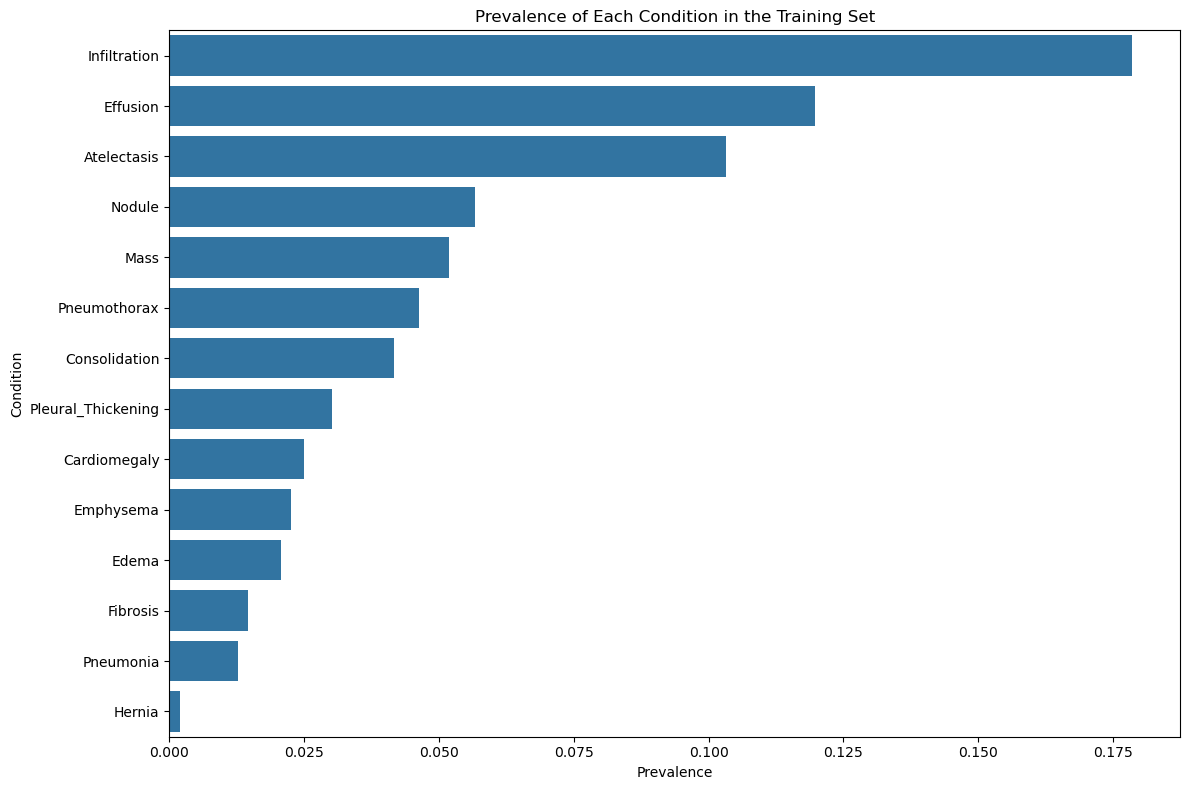


Visualizing sample images...


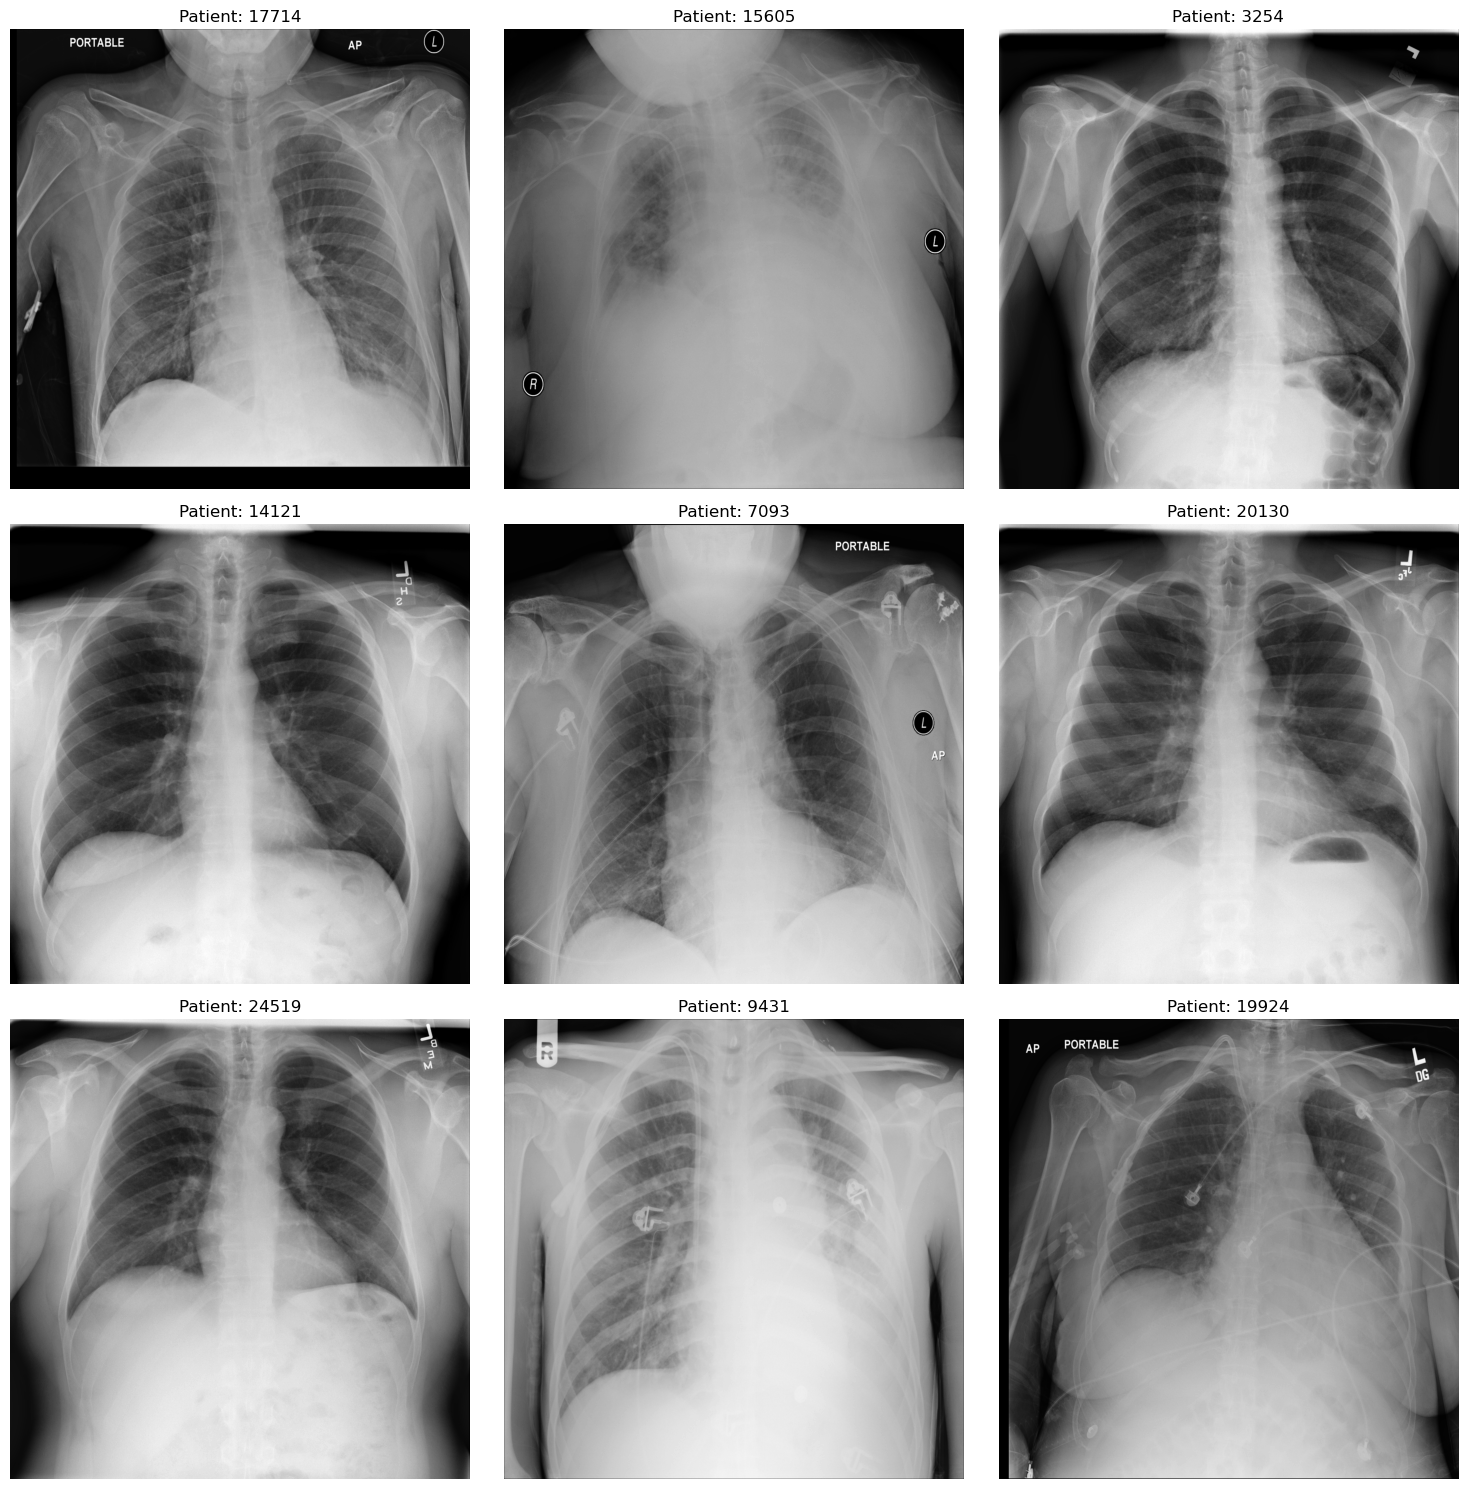


Analyzing image properties...


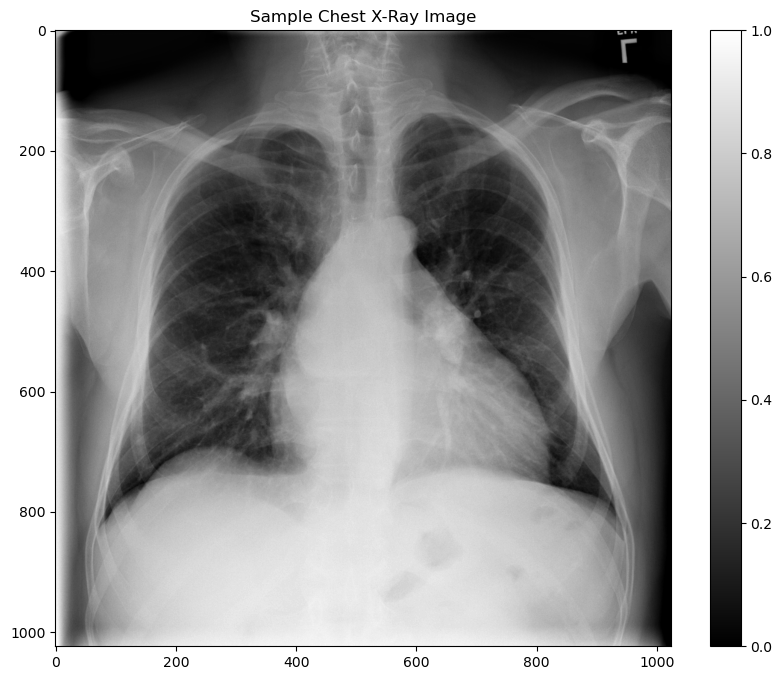

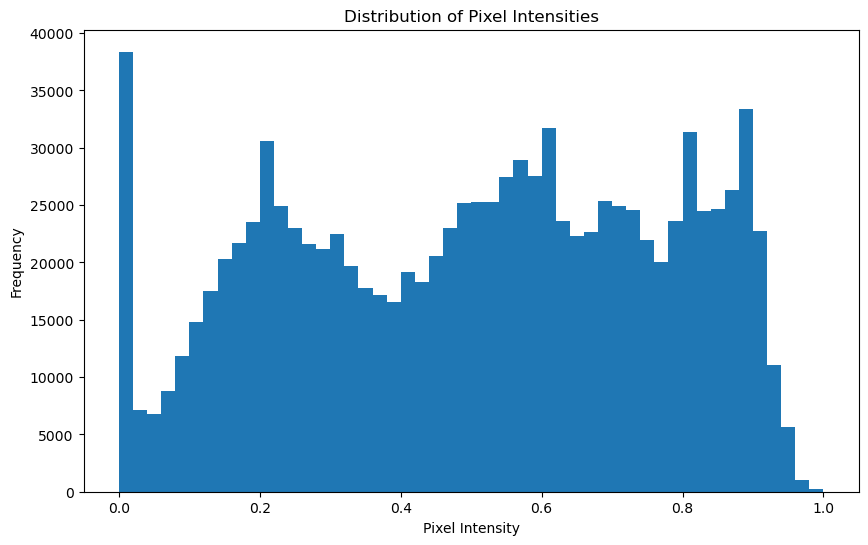

Image shape: (1024, 1024)
Pixel value range: 0.0 to 1.0
Mean pixel value: 0.5025
Pixel standard deviation: 0.2644

Creating data generators...
Found 91141 non-validated image filenames.
Found 10029 non-validated image filenames.
Found 10950 non-validated image filenames.

Building and compiling model...

Training model...
Epoch 1/30


In [ ]:
# Execute the main function if run as a script
if __name__ == "__main__":
    main()
    
    # Optional: After training, you can run these additional analyses
    
    # Load the best model and normalization parameters
    paths = setup_paths()
    model = build_model(num_classes=14, weights_path=os.path.join(paths['model_dir'], 'best_model.h5'))
    
    # Load data
    image_map = find_all_images(paths['base_dir'])
    train_df, valid_df, test_df, conditions = prepare_data(paths, image_map)
    
    # Load or recompute normalization parameters
    _, test_generator, norm_stats = get_validation_test_generators(
        train_df, valid_df, test_df, 
        image_col='path', 
        label_cols=conditions, 
        batch_size=32
    )
    
    # Analyze errors
    analyze_classification_errors(model, test_generator, test_df, conditions, 
                                norm_stats[0], norm_stats[1])
    
    # Visualize attention maps
    visualize_attention_map_on_dataset(model, test_df, conditions, 
                                     norm_stats[0], norm_stats[1])
    
    # Create and demonstrate inference pipeline
    predict_fn = create_deployment_pipeline(model, norm_stats[0], norm_stats[1])
    demo_inference_pipeline(predict_fn, test_df, conditions)
    
    # Save deployment artifacts
    save_deployment_artifacts(model, norm_stats[0], norm_stats[1], conditions, paths['output_dir'])